# Chapter 4. Training Models

到目前为止，我们主要将机器学习模型及其训练算法视为黑匣子。如果您在前几章中完成了一些练习，您可能会惊讶于在不了解引擎下内容的情况下可以完成多少工作：您优化了回归系统，改进了数字图像分类器，甚至从头开始构建了垃圾邮件分类器，所有这些都不知道它们实际上是如何工作的。事实上，在许多情况下，您并不真正需要知道实现细节。

然而，很好地了解事物的工作原理可以帮助您快速了解适当的模型、正确的训练算法以及适合您任务的一组超参数。了解引擎下的内容也将帮助您调试问题并更有效地执行错误分析。最后，本章讨论的大多数主题对于理解、构建和训练神经网络至关重要（在本书第二部分中讨论）。

在本章中，我们将首先研究线性回归模型，这是最简单的模型之一。我们将讨论两种截然不同的方法来训练它：

- 使用直接的 “closed-form” 方程直接计算最适合模型到训练集的模型参数（即最小化训练集上成本函数的模型参数）。
- 使用一种称为梯度下降（GD）的迭代优化方法，逐渐调整模型参数，以最小化训练集的成本函数，最终收敛到与第一种方法相同的参数集。我们将研究梯度下降的几种变体，当我们在第二部分研究神经网络时，我们将一次又一次地使用这些变体：Batch GD、Mini-batch GD 和 Stochastic GD。

接下来，我们将研究多项式回归，这是一个更复杂的模型，可以适应非线性数据集。由于该模型的参数比线性回归多，因此它更容易过拟合训练数据，因此我们将研究如何使用学习曲线检测是否如此，然后我们将研究几种可以降低过拟合训练集风险的正则化技术。

最后，我们将研究另外两个通常用于分类任务的模型：Logistic Regression 和 Softmax Regression。

> WARNING: 本章将有相当多的数学方程，使用线性代数和微积分的基本概念。要理解这些方程，您需要知道什么是向量和矩阵；如何转置它们、乘以它们和逆它们；以及什么是偏导数。如果您不熟悉这些概念，请浏览在线补充材料中作为Jupyter笔记本提供的线性代数和微积分入门教程。对于那些真正对数学过敏的人，你仍然应该读完这一章，简单地跳过方程；希望文本足以帮助你理解大多数概念。

## Linear Regression

在第一章中，我们看到 life satisfaction 的简单的回归： 

$$life\_satisfaction = \theta_0 + \theta_1 \times GDP\_per\_capita$$

模型是输入特征 $GDP\_per\_captita$ 的线性函数。 $\theta_0$ 和 $\theta_1$ 是模型的参数。

更一般地说，线性模型通过简单计算输入特征的加权和，加上一个称为偏差项（也称为 intercept 项）的常量来进行预测：

$$\hat y = \theta_0 + \theta_1x_1 + \theta_2 x_2 + ... + \theta_n x_n$$



## The Normal Equation

为了找到最小化成本函数的 $\theta$ 值，有一个 ` closed-form` ——换句话说，一个直接给出结果的数学方程。这个方程叫做 `Normal Equation`

$$\hat \theta = (X^TX)^-1X^Ty$$

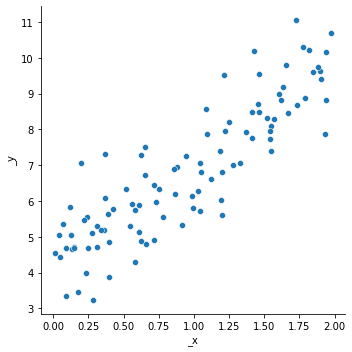

In [1]:
import numpy as np
import seaborn as sns

np.random.seed(42)

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

sns.relplot(x=X.squeeze(), y=y.squeeze())

现在让我们使用 `Normal Equation` 计算 $\hat \theta$。 我们将使用 Numpy 的线性代数模块(`np.linalg`) 中的 `inv` 函数计算一个矩阵的逆， 并且使用 `dot()` 方法计算矩阵乘法：

In [2]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

我们用于生成数据的函数是 $y = 4 + 3x_1 + \text{Gassian noise}$ 

In [3]:
theta_best

array([[4.21509616],
       [2.77011339]])

我们希望 $\theta_0 = 4$ 和 $\theta_1 = 3$ 而不是 $\theta_0 = 4.215$ 和 $\theta_1 = 2.770$。 足够近，但噪音使得无法恢复原始函数的确切参数。

In [4]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

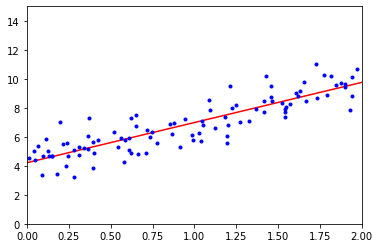

In [6]:
from matplotlib import pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

使用 Scikit-Learn 实现线性回归很简单：

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [8]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

`LinearRegression` 类基于 `scipy.linalg.lstsq()` 函数(名字代表 "least squares")， 你可以直接调用:

In [9]:
theta_best_svd, resisuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

函数计算 $\hat \theta = X^+y$， 其中 $X^+$ 是 $X$ 的伪逆(Moore-Penrose逆)。 你可以使用 `np.linalg.pinv()` 来直接计算伪逆：

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

伪逆使用奇异值分解(SVD)计算得到， 其可以将训练集矩阵 $X$ 分解为三个矩阵的乘法 $U \Sigma V^T$ (`numpy.linalg.svd()`)。 伪逆可以被计算为 $X^+ = V \Sigma^+ U^T$。为了计算矩阵 $\Sigma^+$, 该算法将 $\Sigma$ 设置为零，所有小于微小阈值的值，然后用它们的逆值替换所有非零值，最后转置生成的矩阵。这种方法比计算 Normal Equation 更有效，而且它很好地处理边缘情况：事实上，如果矩阵 $X^T X$ 不是可逆的（即单数），例如如果 $m < n$ 或某些特征是多余的，则 Normal Equation 可能无法工作，但伪逆总是有定义的。

## Computational Complexity

Normal Equation 计算 $X^TX$ 的逆， 其实一个 $(n + 1) \times (n + 1)$ 的矩阵。 求逆的计算复杂度通常为 $O(n^{2.4})$ 到 $O(n^3)$，取决于实现的方法。 换句话说， 如果你的特征数量加倍， 你的计算次数将乘以 $2^{2.4}=5.3$ 或 $2^3 = 8$。

Scikit-Learn 中的 `LinearRegression` 类使用的 SVD 方法复杂度大约为 $O(n^2)$。 如果特征数量翻倍， 你乘法的次数增加大约4倍。

> WARNING: 当特征数量增加时，Normal Equation 和 SVD 方法都会变得非常缓慢。 从积极的一面来看，它们对训练集的样本数量都是线性的，因此它们可以有效地处理大型训练集，前提是它们可以放到内存中。


此外，一旦您训练了线性回归模型（使用 Normal Equation 或任何其他算法），预测速度非常快：就您要进行预测的实例数量和特征数量而言，计算复杂性都是线性的。换句话说，对两倍的实例（或两倍的特征）进行预测大约需要两倍的时间。

现在，我们将研究一种非常不同的方法来训练线性回归模型，该模型更适合具有大量特征或太多训练样本无法放入内存的情况。



## Gradient Descent

`Gradient Descent` 是找到最优解的通用优化算法。



## Batch Gradient Descent

相比于单独对他们计算偏微分， 亦可以直接一次性计算他们。 梯度向量, 表示为 $\nabla_\theta MSE(\theta)$, 包含代价函数的所有偏微分：

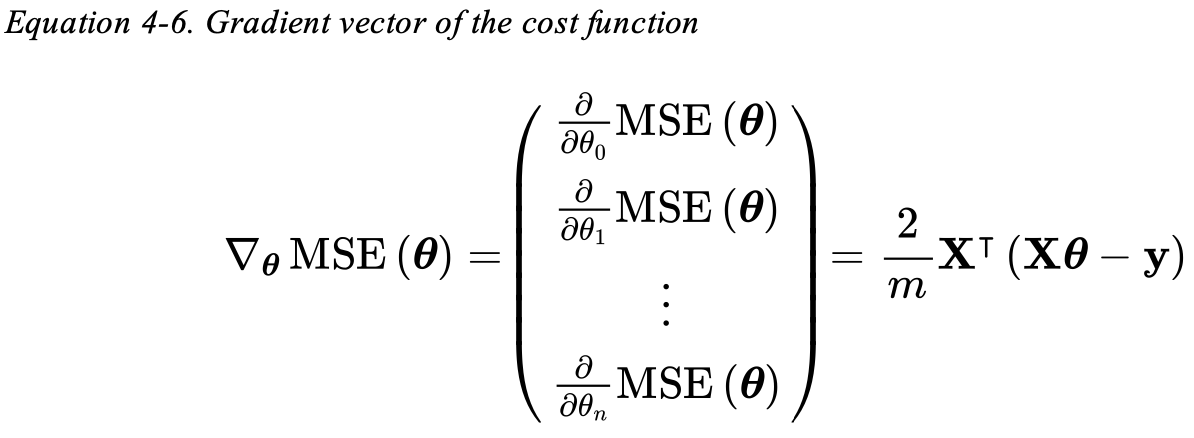

In [11]:
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [12]:
theta

array([[4.21509616],
       [2.77011339]])

## Stochastic Gradient Descent

批量梯度下降的主要问题是，它使用整个训练集来计算每一步的梯度，这使得训练集很大时速度非常慢。在相反的极端，随机梯度下降在每一步的训练中选择一个随机样本，并仅根据该单个样本计算梯度。显然，一次处理单个样本使算法更快，因为它在每次迭代中几乎没有数据需要操作。它还可以在巨大的训练集上进行训练，因为每次迭代只需要内存中一个样本。

另一方面，由于其随机性质，该算法远不如批量梯度下降规律：成本函数不会轻易下降到最低值，而是会上下反弹，仅平均下降。

In [13]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [14]:
theta

array([[4.18475289],
       [2.73036719]])

In [17]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [18]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.22609703]), array([2.79227913]))

## Mini-batch Gradient Descent

我们将研究的最后一个梯度下降算法称为 `Mini-batch Gradient Descent`。一旦您了解 Batch 和 Stochastic 梯度下降，就很容易理解：在每个步骤中，Mini-batch GD在称为mini-batches的小随机样本集上计算梯度，而不是基于完整的训练集（如Batch GD）或仅基于一个样本（如Stochastic GD）计算梯度。

## Polynomial Regression

如果您的数据比直线更复杂怎么办？令人惊讶的是，您可以使用线性模型来适应非线性数据。一个简单的方法是将每个特征的幂添加为新特征，然后在这组扩展的特征上训练线性模型。这种技术被称为 `Polynomial Regression`。

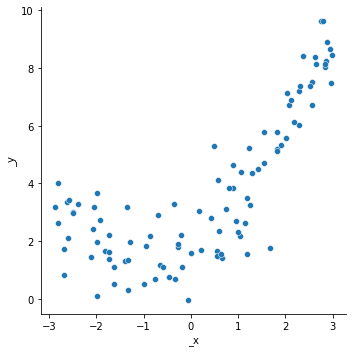

In [19]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

sns.relplot(x=X.squeeze(), y=y.squeeze())

显然，直线永远无法正确地匹配这些数据。所以，让我们使用Scikit-Learn的 `PolynomialFeatures` 类转换我们的训练数据，将训练集中每个特征的平方添加为新特征（在这种情况下只有一个特征）：

In [23]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [24]:
X[0]

array([2.94407494])

In [25]:
X_poly[0]

array([2.94407494, 8.66757727])

`X_poly` 现在包含这个特征的平方加上原始特征 $X$。 现在你可以使用这个拓展的训练数据拟合 `LinearREgression` 模型：

In [26]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.89554823]), array([[0.95707476, 0.49025797]]))

模型估计为 $y = 0.49 x_1^2 + 0.95 x_1 + 1.89$， 而原始函数为 $y = 0.5 x_1^2 + 1.0 x_1 + 2 + \text{Gaussian noise}$

请注意，当有多个特征时，多项式回归能够找到特征之间的关系（这是普通线性回归模型无法做到的）。这是由 `PolynomialFeatures` 加上所有特征到给定阶次的组合做到的。 例如，如果有两个特征 a 和 b， `degree=3` 的 `PolynomialFeatures` 会加上特征 $a^2$, $a^3$， $b^2$ 和 $b^3$， 以及他们的组合 $ab$, $a^2b$ 和 $ab^2$。

> WARNING: PolynomialFeatures(degree=d) 转换包含 n 个特征的 array 为 包含 $\frac{(n+d)!}{d!n!}$ 个特征的 array。

## Learning Curve

如果您执行高阶多项式回归，您可能会比普通线性回归更容易训练数据。例如，图4-14将 300-degree 多项式模型应用于前面的训练数据，并将结果与纯线性模型和二次模型（二度多项式）进行比较。注意 300-degree 多项式模型如何摆动，以尽可能接近训练样本。

这个高度多项式回归模型严重过拟合训练数据，而线性模型则不拟合训练数据。在这种情况下，最具有泛化能力的模型是二次模型，这是有道理的，因为数据是使用二次模型生成的。但一般来说，您不知道是什么函数生成数据，那么您如何决定您的模型应该有多复杂？您如何判断您的模型是否过拟合或欠适合数据？

在第2章中，您使用交叉验证来估计模型的泛化性能。如果一个模型在训练数据上表现得很好， 但是早交叉验证指标上泛化很差， 那么你的模型就过拟合了。 如果两者都表现不佳，那么它就欠拟合。这是判断模型何时过于简单或过于复杂的一种方式。

另一种判断方式是查看学习曲线：这些是模型在训练集上的性能图，以及作为训练集大小（或训练迭代）的函数的验证集。要生成绘图，请在训练集的不同大小的子集上对模型进行几次训练。以下代码定义了一个函数，给定一些训练数据，该函数绘制模型的学习曲线：

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

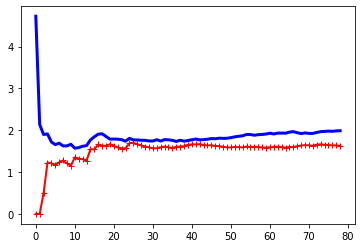

In [30]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

这个欠拟合的模型值得一些解释。首先，让我们看看训练数据的性能：当训练集中只有一两个样本时，模型可以完美地匹配它们，这就是为什么曲线从零开始。但是，随着新样本添加到训练集中，模型不可能完美地匹配训练数据，这既是因为数据很嘈杂，也根本不是线性的。因此，训练数据上的错误会上升到达到顶峰，此时向训练集添加新样本不会使平均错误好或者坏。现在，让我们看看模型在验证数据上的性能。当模型在很少的训练样本上进行训练时，它无法正确泛化，这就是为什么验证错误最初相当大的原因。然后，当模型显示更多训练样本时，它会学习，因此验证错误会慢慢下降。然而，一条直线无法很好地建模数据，因此误差最终位于高原，非常接近另一条曲线。

这些学习曲线是欠拟合模型的典型特征。两条曲线都已达到 plateau；它们很近，相当高。

> TIP: 如果您的模型欠拟合训练数据，添加更多训练样本将无济于事。您需要使用更复杂的模型或想出更好的特征。

现在让我们看看相同数据上的 10-degree 多项式模型的学习曲线:

(0.0, 3.0)

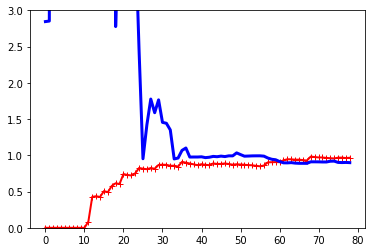

In [39]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)
plt.ylim(0, 3)

这些学习曲线看起来有点像以前的曲线，但有两个非常重要的区别：

- 训练数据的误差远低于线性回归模型。
- 曲线之间有一个空隙。这意味着模型在训练数据上的表现明显优于验证数据，这是过拟合模型的标志。然而，如果您使用更大的训练集，这两个曲线将继续更接近。

> TIP: 改进过拟合模型的一种方法是向其提供更多训练数据，直到验证误差达到训练误差。


> **THE BIAS/VARIANCE TRADE-OFF**: 统计学和机器学习的一个重要理论结果是，模型的泛化误差可以表示为三个非常不同的误差的总和：
>
> **Bias**: 泛化误差的这一部分是由于错误的假设，例如假设数据实际上是二次数据时是线性的。高偏差模型最有可能欠拟合训练数据
>
> **Variance**: 这部分是由于模型对训练数据的微小变化过于敏感。具有多自由度的模型（如高阶多项式模型）可能具有高方差，因此过拟合训练数据。
>
> **Irreducible error**: 这部分是由于数据本身的嘈杂。减少这部分错误的唯一方法是清理数据（例如，修复数据源，如损坏的传感器，或检测和删除异常值）。
>
> 增加模型的复杂性通常会增加其方差并减少其偏差。相反，降低模型的复杂性会增加其偏差并减少其方差。这就是为什么它被称为权衡。

## Regularized Linear Models

正如我们在第1章和第2章中看到的那样，减少过拟合的一个好方法是规范模型（即约束它）：它的自由度越少，就越难过拟合数据。正则化多项式模型的一个简单方法是减少多项式阶数。

对于线性模型，正则化通常通过约束模型的权重来实现。我们现在将看看Ridge Regression，Lasso Regression, 和 Elastic Net, 其实现以三种不同的方式约束权重。

### Ridge Regression

`Ridge Regression`(Tikhonov regularization) 是线性回归的约束版本， 在代价函数上加入一项等于 $\alpha \sum_{i=1}^n \theta_i^2$ 的正则项。这迫使学习算法不仅要拟合数据，还要尽可能小地保持模型权重。请注意，规范化项只能在训练期间添加到代价函数中。模型经过训练后，您希望使用非正则性能指标来评估模型的性能。

> Note: 训练期间使用的代价函数与用于测试的性能指标不同是很常见的。除了正则化外，它们可能不同的另一个原因是，良好的训练代价函数应该具有优化友好的导数，而用于测试的性能指标应尽可能接近最终目标。例如，分类器通常使用对数损失等代价函数进行训练，但使用精度/召回进行评估。

超参数 $\alpha$ 控制您想要对模型进行正则化的程度。如果 $\alpha = 0$，那么 Ridge 回归只是线性回归。如果 $\alpha$ 非常大，那么所有权重最终都非常接近于零，结果是一条穿过数据平均值的平坦线。方程4-8提出了Ridge回归代价函数。

$$J(\theta) = MSE(\theta) + \alpha \frac{1}{2} \sum_{i=1}^n \theta_i^2$$

注意偏置项 $\theta_0$ 没有被规范化(求和项从1开始)。 如果我们定义特征权重($\theta_1$ 到 $\theta_n$) 为 $w$， 那么正则化项等于 $\frac{1}{2}(\|w\|_2))^2$， 其中 $\|w\|_2$ 表示权重向量的 $l_2$ 范数。 对于梯度下降， 我们在 MSE 梯度向量上加上 $\alpha w$

> WARNING: 在执行 Ridge Regression 之前，缩放数据（例如，使用 `StandardScaler`）很重要，因为它对输入特征的规模很敏感。大多数正则化模型都是如此。

图4-17显示了几个使用不同 $\alpha$ 值在某些线性数据上训练的 Ridge 模型。在左侧，使用普通的 Ridge 模型，导致线性预测。在右侧， 数据首先使用 `PolynomialFeatures(degree=10)` 拓展， 然后使用 `StandarScaler`， 最后 Ridge 模型使用得到的特征： 这是带有Ridge正则化的多项式回归。注意增加 $\alpha$ 如何导致更平坦（即不那么极端、更合理）的预测，从而减少模型的方差，但增加了其偏差。

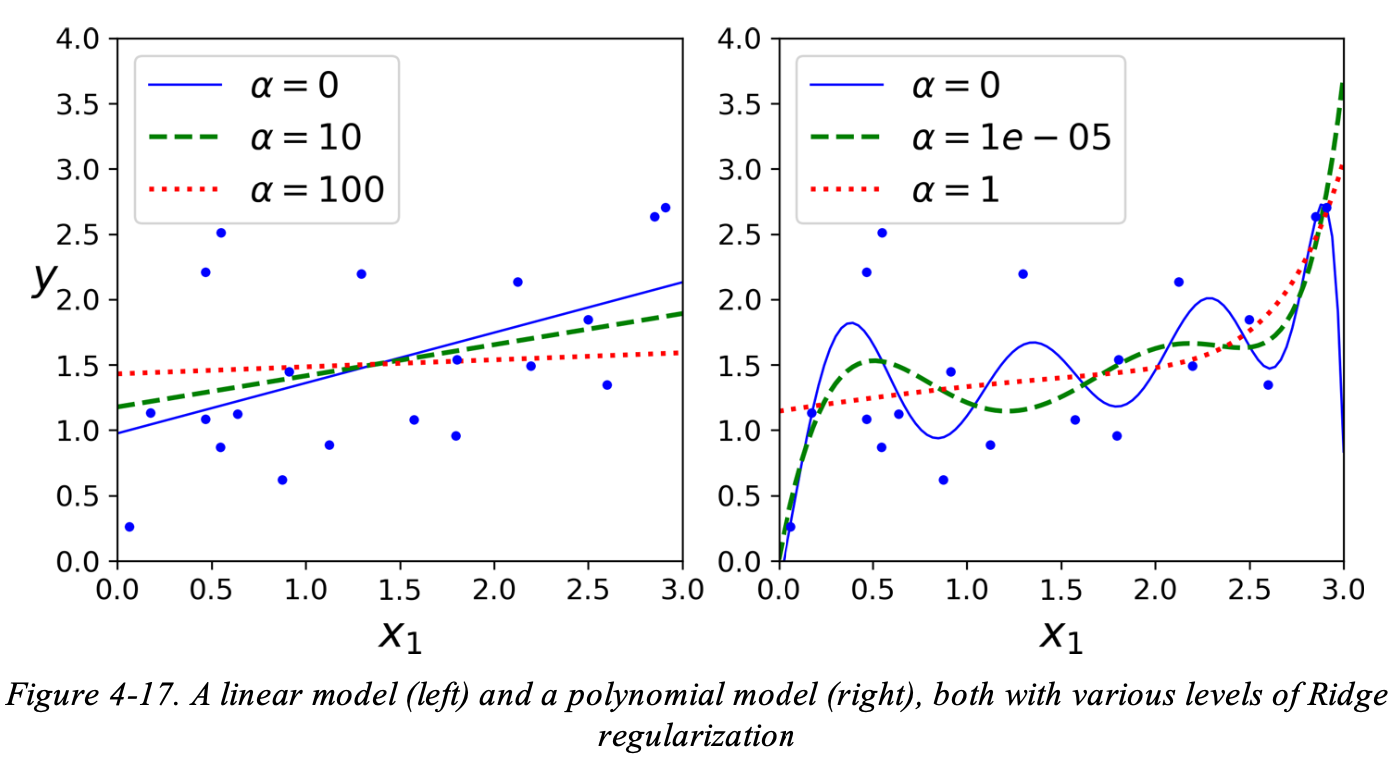

与线性回归一样，我们可以通过计算 closed-form 方程或执行梯度下降来执行 Ridge Regression。利弊是相同的。Equation 4-9 展示了 close-form 解， 其中 $A$ 是 $(n + 1) \times (n + 1)$  的 identity matrix。

$$\hat \theta = (X^TX + \alpha A)^{-1}X^Ty$$

以下是如何以 close-form 解 使用 Scikit-Learn 执行 Ridge 回归：

In [41]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.07720864]])

下面是使用随机梯度下降：

In [43]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.06484192])

`penalty` 超参数设置要使用的正则化项类型。 "l2" 表示你想要 SGD 增加一个正则化项在代价函数上， 其等于权重向量的 l2 范数平方的一半: 这是简单的 Ridge Regression.

## Lasso Regression

`Least Absolute Shrinkage and Selection Operator Regression` (Lasso Regression) 是另一个线性回归的正则化版本： 就像Ridge回归一样，它为成本函数添加了一个正则化项，但它使用权重向量的 l1 范数，而不是l2范数的平方的一半：

$$J(\theta) = MSE(\theta) + \alpha \sum_{i=1}^n |\theta_i|$$

图4-18显示了与图4-17相同的东西，但用 Lasso 模型取代了Ridge模型，并使用较小的 $\alpha$ 值。

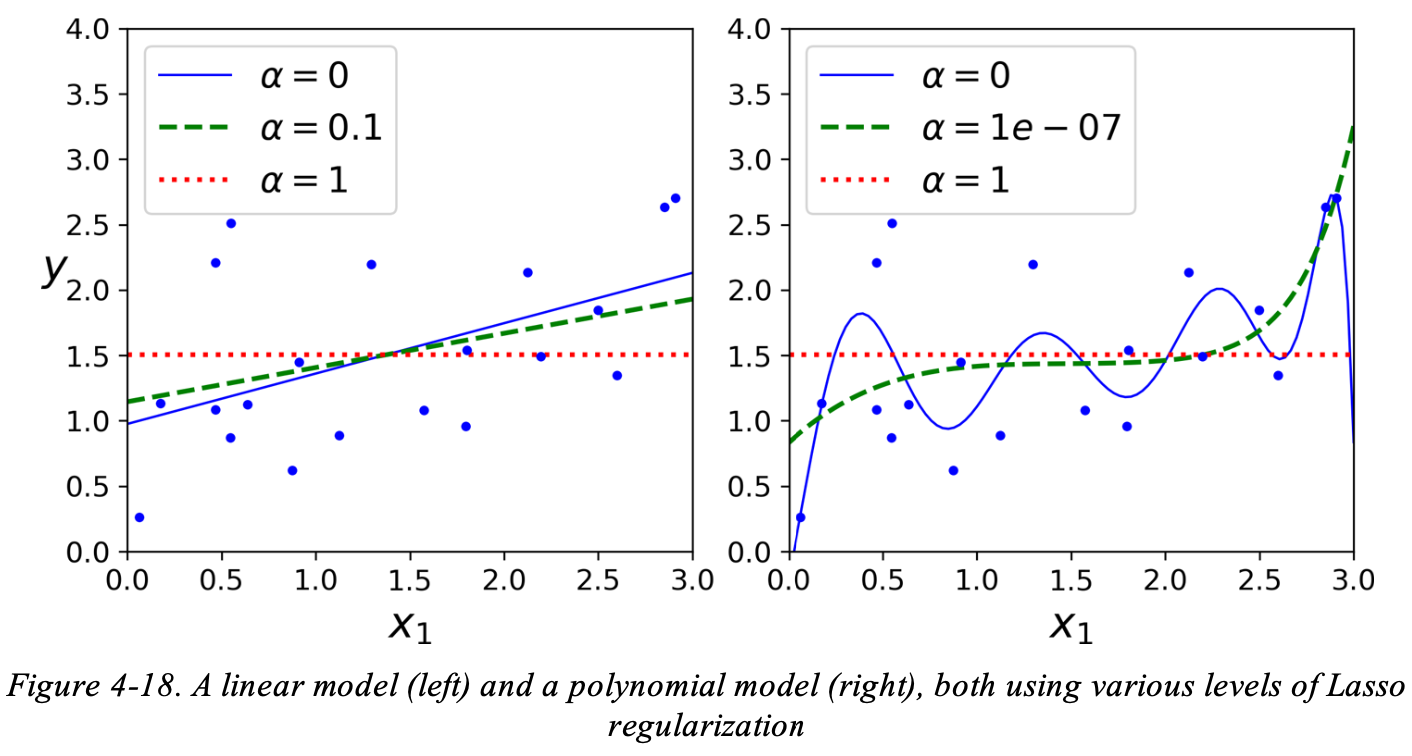

Lasso 回归的一个重要特征是，它倾向于消除最不重要特征的权重（即将其设置为零）。例如，图4-18中右图中的虚线($\alpha = 10^{-7}$）看起来是二次的，几乎是线性的：高阶多项式特征的所有权重都等于零。换句话说，Lasso 回归会自动执行特征选择并输出稀疏模型（即很少有非零特征权重）。

通过查看图4-19，您可以了解为什么会这样：轴代表两个模型参数，背景轮廓代表不同的损失函数。在左上角的图中，轮廓表示 $\text{l1 loss} (|\theta_1| + |\theta_2|)$，当你接近任何轴时，损失会线性下降。例如，如果您将模型参数初始化为 $\theta_1 = 2$ 和 $\theta_2 = 0.5$，运行梯度下降将平等地减少这两个参数（如虚线所示）；因此，$\theta_2$ 将首先达到0（因为它一开始就接近0）。之后，梯度下降将沿着 gutter 滚动，直到达到 $\theta_1 = 0$。 在右上图中，轮廓表示 Lasso 的代价函数（即 MSE 代价函数加上 l1 损失）。小白圆显示了梯度下降优化一些模型参数的路径，这些参数在 $\theta_1 = 0.25$ 和 $\theta_2 = –1$ 周围初始化：再次注意路径如何快速到达 $\theta_2 = 0$，然后沿着 gutter 滚动，最终围绕全局最佳值（以红色方块表示）。如果我们增加 $\alpha$，全局最优将沿着虚线黄线向左移动，而如果我们减少 $\alpha$，全局最优将向右移动（在本例中，非正则 MSE 的最佳参数是 $\theta_1 = 2$ 和 $\theta_2 = 0.5$）。


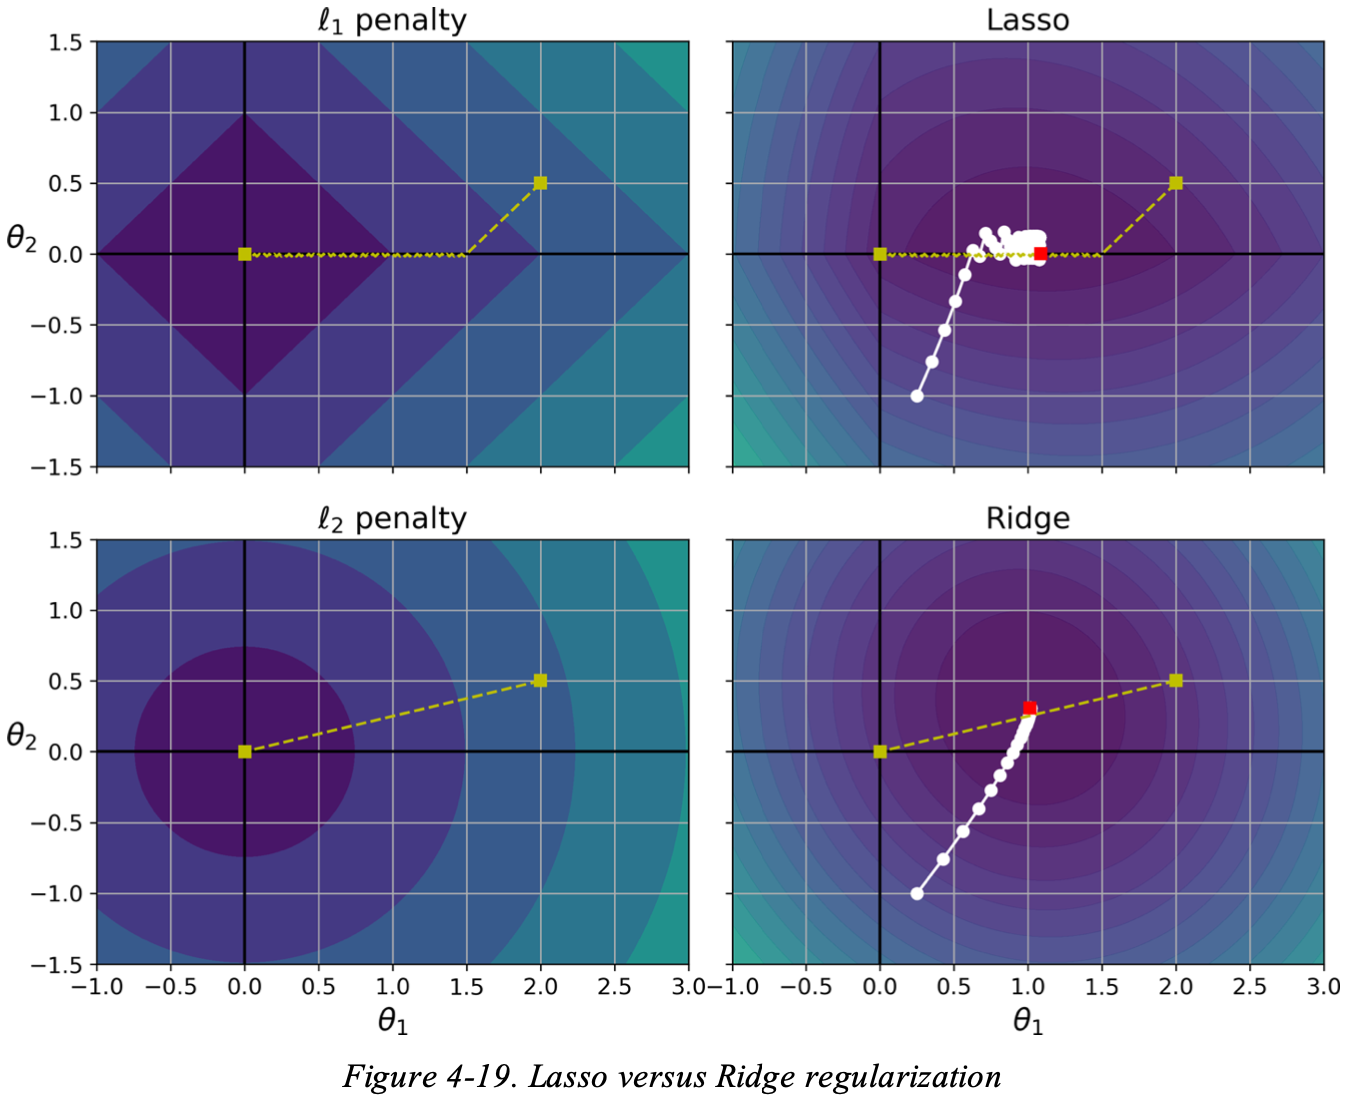

两个底层 plot 显示了相同的东西，但取而代之的是 l2 penalty。在左下角的绘图中，您可以看到 l2 损失随着到原点的距离而减少，因此梯度下降只是朝着该点走一条直线路径。在右下图中，轮廓表示 Ridge 回归的代价函数（即 MSE 代价函数加上 l2损失）。 Lasso 有两个主要不同。 首先，随着参数接近全局最佳值，梯度变小，因此梯度下降自然减慢，这有助于收敛（因为没有反弹）。其次，当您增加 $\alpha$ 时，最佳参数（以红色方块表示）越来越接近原点，但它们永远不会被完全消除。

> TIP: 为了避免梯度下降在使用 Lasso 时在最后围绕最佳值弹跳，您需要在训练期间逐渐降低学习率（它仍然会围绕最佳值反弹，但步数会越来越小，因此会收敛）。


Lasso 代价函数 在 $\theta_i = 0$ 时不可微（对于i = 1, 2, ⋯, n），但如果使用 subgradient vector $g$，而任何 $\theta_i = 0$ 时，梯度下降仍然有效。方程4-11显示了一个 subgradient vector 方程，您可以使用 Lasso 代价函数进行梯度下降。

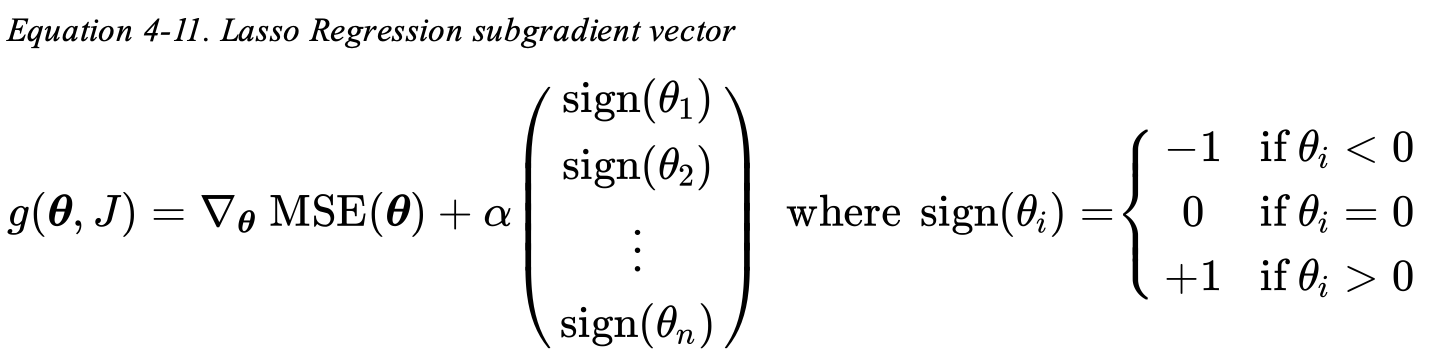


In [46]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.04247738])

In [47]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty="l1")
sgd_reg.fit(X, y)
sgd_reg.predict([[1.5]])

/Users/shawnd/miniforge3/envs/keras/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([5.06929295])

## Elastic Net

Elastic Net 是 Ridge 回归和 Lasso 回归之间的中间地带。正则化项是 Ridge 和 Lasso 正则化项的简单组合，您可以控制混合比率r。当r = 0时，Elastic Net 等价于 Ridge 回归，当 r = 1 时，它等价于 Lasso 回归（见方程4-12）。

$$J(\theta) = MSE(\theta) + r \alpha \sum_{i=1}^n |\theta_i| + \frac{1-r}{2} \alpha \sum_{i=1}^n \theta_i^2$$


那么，你什么时候应该使用纯线性回归（即没有任何正则化）、Ridge、Lasso 或 Elastic Net？几乎总是最好至少有一点正则化，所以通常你应该避免普通的线性回归。Ridge是一个很好的默认值，但如果您怀疑只有少数特征有用，您应该更喜欢 Lasso 或Elastic Net，因为它们往往会将无用特征的权重降低到零，正如我们所讨论的。一般来说，Elastic Net 比 Lasso 更受欢迎，因为当特征数量大于训练样本数量或几个特征密切相关时，Lasso 的行为可能不稳定。 

以下是使用 Scikit-Learn 的 ElasticNet 简短示例（ `l1_ratio` 对应于混合比率 `r`）：

In [48]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.04191364])

## Early Stopping

将梯度下降等迭代学习算法正规化的一个截然不同的方法是，一旦验证误差达到最低水平，就停止训练。这被称为 Early Stopping。图4-20显示了正在使用批量梯度下降训练的复杂模型(在这种情况下，是高度多项式回归模型)。随着算法学习 epochs 的流逝，训练集上的预测误差（RMSE）下降，以及验证集上的预测误差下降。然而，一段时间后，验证错误停止减少并开始恢复。这表明模型开始过拟合训练数据。 提前停止，一旦验证错误达到最低值，您就可以停止训练。这是一种如此简单高效的正则化技术，以至于杰弗里·辛顿称其为“美丽的免费午餐”。

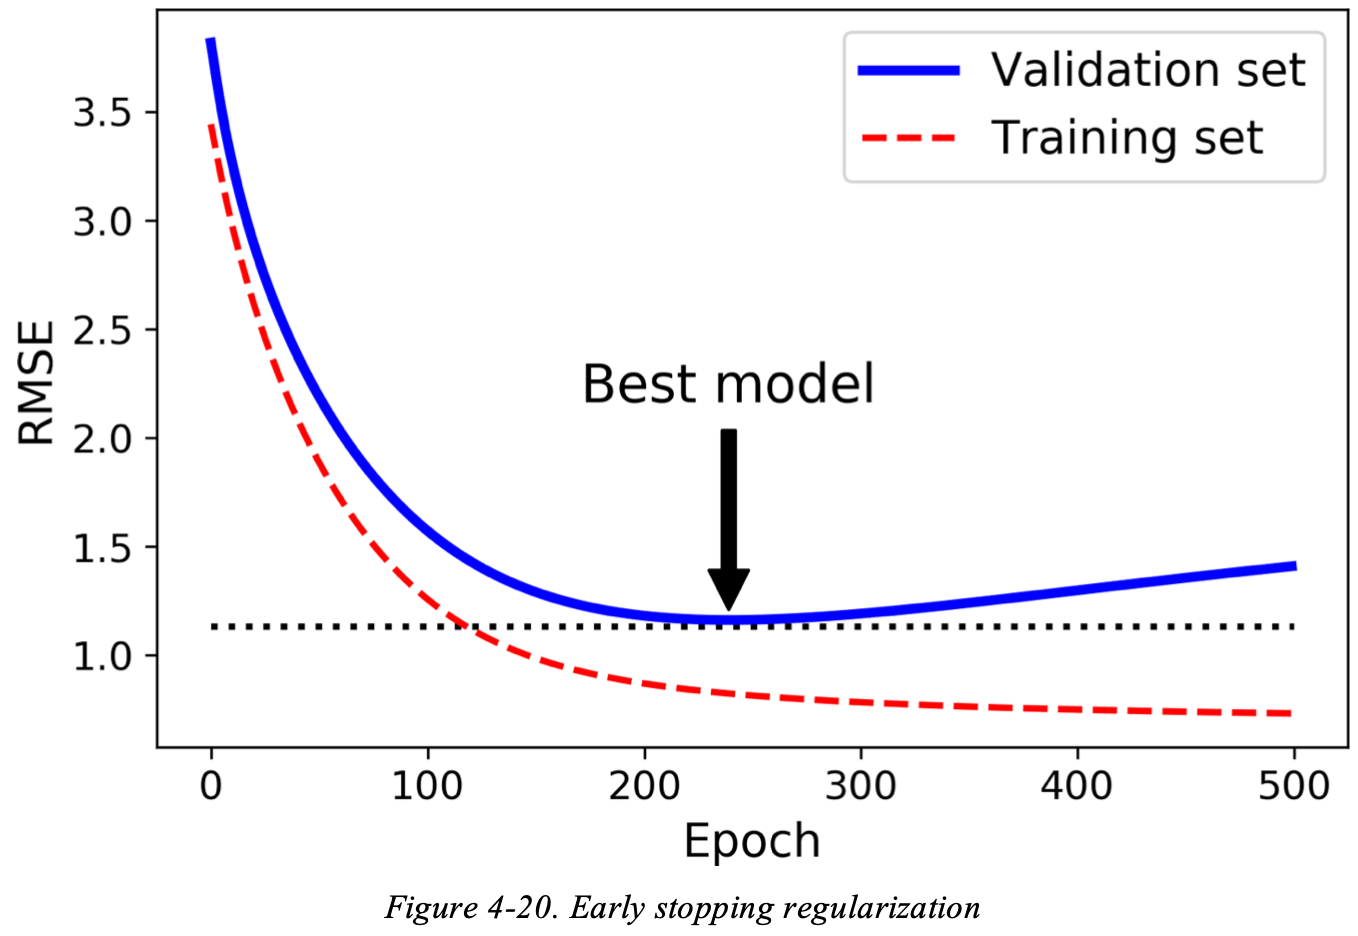

> TIP: 使用 Stochastic 和 Mini-batch Gradient Descent，曲线不那么光滑，可能很难知道您是否已经达到最低值。一种解决方案是在验证错误超过最小值一段时间后（当您确信模型不会做得更好时）停止，然后将模型参数回滚到验证错误最低点。

In [54]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel())
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

请注意 `warm_start=True`，当调用 `fit()` 方法时，它会继续在中断的地方进行训练，而不是从头开始重新启动。

## Logistic Regression

正如我们在第一章中讨论的那样，一些回归算法可用于分类（反之亦然）。逻辑回归（也称为Logit回归）通常用于估计实例属于特定类的概率（例如，此电子邮件是垃圾邮件的概率是多少？）。如果估计概率大于50%，则模型预测实例属于该类（称为正类，标记为“1”），否则它预测它不属于该类（即它属于负类，标记为“0”）。这使它成为一个二分类器。

### Estimating Probabilities

那么逻辑回归是如何运作的呢？就像线性回归模型一样，逻辑回归模型计算输入特征的加权和（加上偏置项），但是输出与线性回归模型的输出不同， 它的输出是 logistic。

$$\hat p = h_\theta(x) = \sigma(x^T \theta)$$

logistic —— 表示为 $\sigma(·)$ ——是一个 sigmoid 函数， 其输出值在 0 到 1 之间。


### Decision Boundaries

让我们使用 Iris 数据集来说明逻辑回归。这是一个著名的数据集，包含三种不同物种：Iris setosa、Iris versicolor 和 Iris virginica。

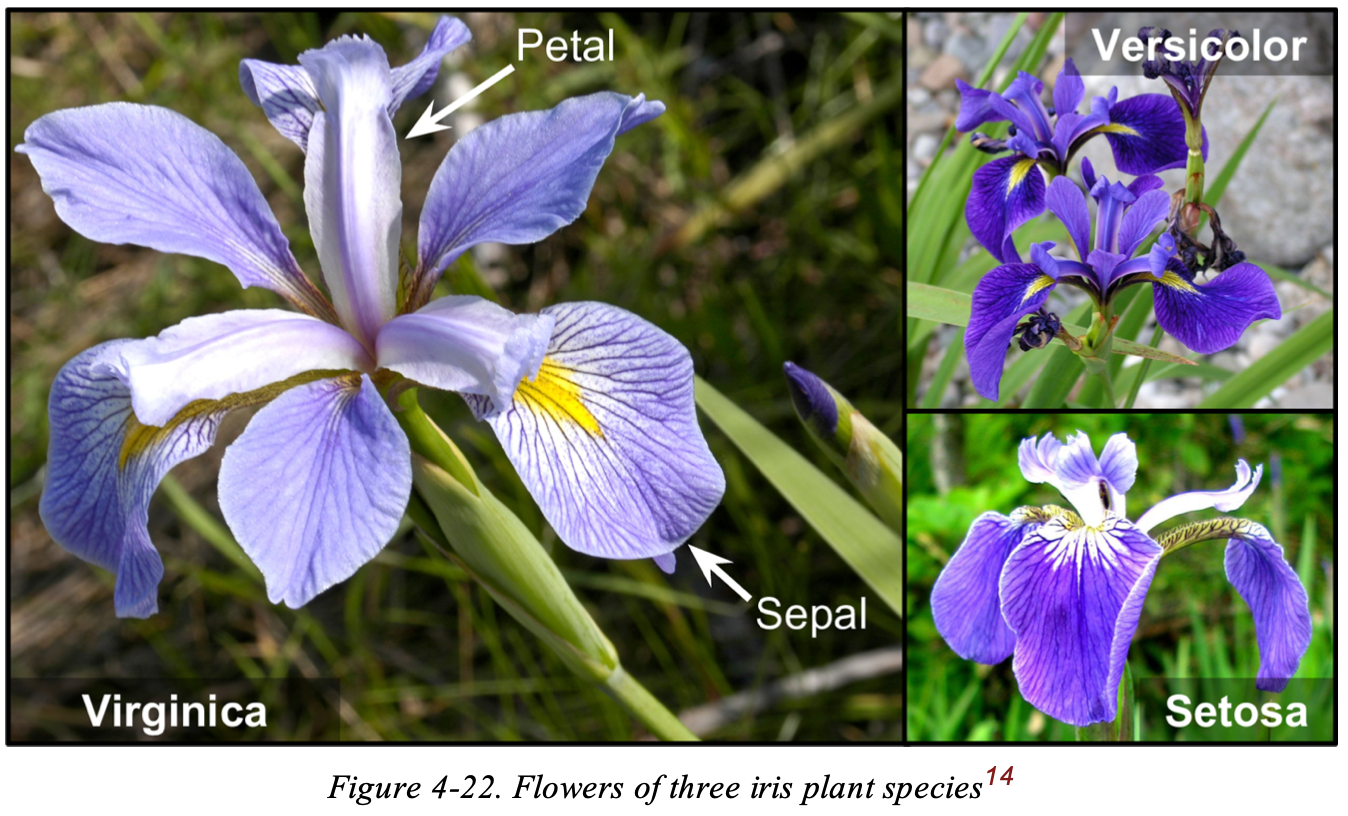

让我们尝试构建一个分类器来检测Iris virginica类型，仅基于花瓣宽度特征。首先，让我们加载数据：

In [55]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [56]:
X = iris["data"][:, 3:]
y = (iris["target"] == 2).astype(np.int)

/var/folders/7q/gtdgjdyn4rn030xffh9zbbrm0000gp/T/ipykernel_44141/4102839179.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int)


现在让我们训练一个逻辑回归模型

In [57]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

让我们看看模型对花瓣宽度从 0厘米 到 3厘米 不等的花朵的估计概率

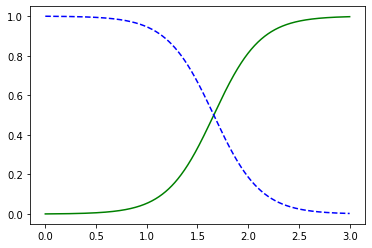

In [60]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")

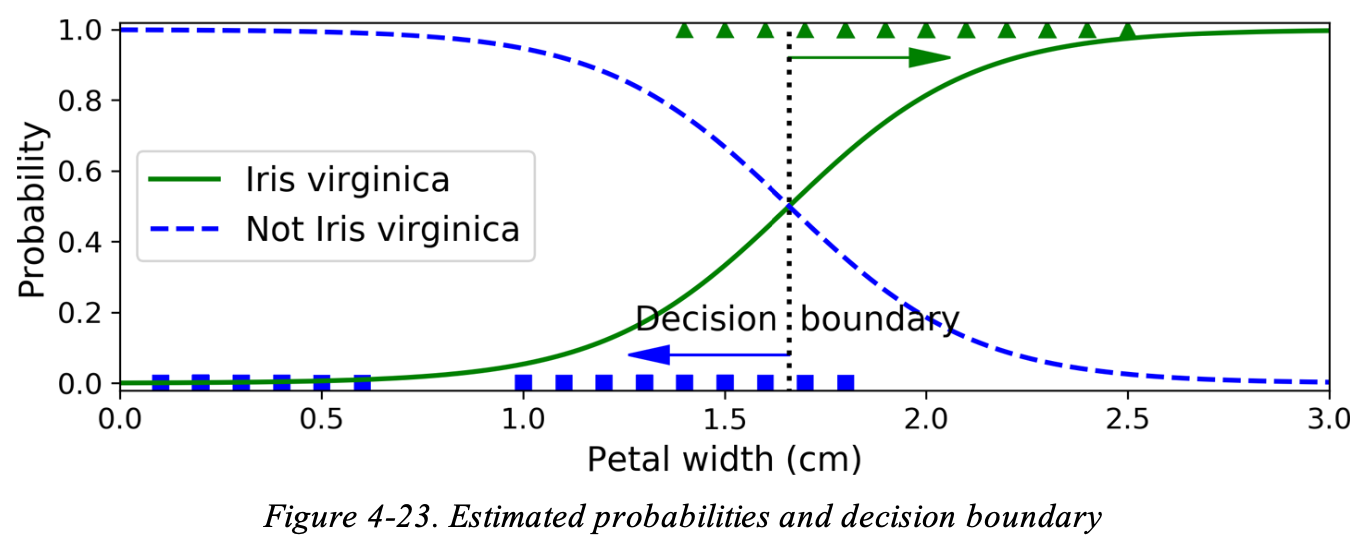

Iris virginica （以三角形表示）的花瓣宽度从 1.4 厘米到 2.5厘米 不等，而其他 iris 花（以正方形表示）的花瓣宽度通常较小，从0.1厘米到1.8厘米不等。请注意，有些重叠。在大约2厘米以上，分类器高度相信这朵花是 Iris virginica（它为该类输出很高的概率），而在1厘米以下，它非常有信心它不是 Iris virginica（“Not Iris virginica”类的概率很高）。在这些极端之间，分类器不确定。但是，如果您要求它预测类（使用 `predict()` 方法而不是 `predict_proba()` 方法），它将返回最有可能的类。因此，有一个约1.6厘米的决策边界，其中两种概率都等于50%：如果花瓣宽度高于1.6厘米，分类器将预测花是 Iris virginica，否则它将预测它不是（即使它不是很自信）：

In [61]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

图4-24显示了相同的数据集，但这次显示了两个特征：花瓣宽度和长度。一旦训练，逻辑回归分类器可以根据这两个特征估计新花是 Iris virginica 的概率。虚线表示模型估计 50% 概率的点：这是模型的决策边界。注意这是一个线性边界。 每条平行线代表模型输出特定概率的点，从15%（左下角）到90%（右上角）。根据模型，右上角线以外的所有花朵都有超过90%的几率成为Iris virginica。

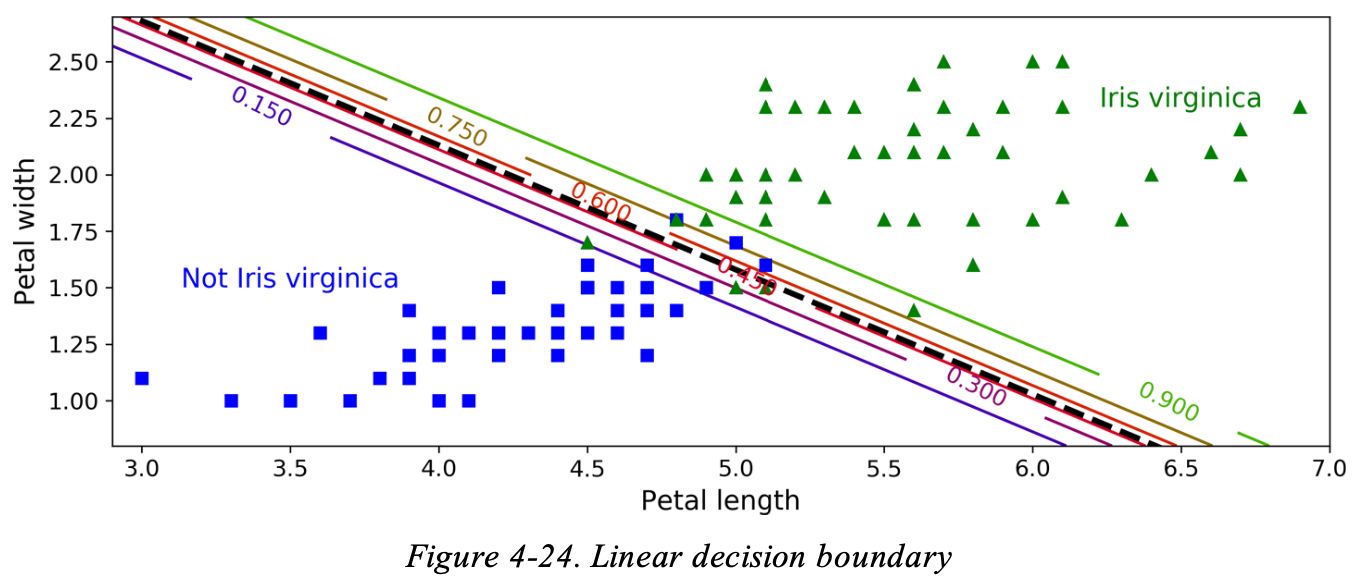

与其他线性模型一样，逻辑回归模型可以使用 l1 或 l2 惩罚进行正则化。Scikit-Learn实际上默认增加了 l2 惩罚。

> NOTE: 控制Scikit-Learn `LogisticRegression` 正则化强度的超参数模型不是 `alpha`（与其他线性模型一样），而是 `C`。 `C` 值越高，模型的正则化就越少。

## Softmax Regression

逻辑回归模型可以推广为直接支持多个类，而无需训练和组合多个二分类器（如第3章所述）。这被称为 `Softmax Regression`，或 `Multinomial Logistic Regression`。

这个想法很简单: 当给定一个样本 `x` 时，Softmax 回归模型首先为每个类 k 计算一个分数 $s_k(x)$，然后通过对分数应用 Softmax 函数(也称为归一化指数)来估计每个类的概率。计算 $s_k(x)$ 的方程应该看起来很熟悉，因为它就像线性回归预测的方程一样:

$$s_k(x) = x^T\theta^{(k)}$$

请注意，每个类都有自己的专用参数向量 $\theta^{(k)}$。所有这些向量通常作为行存储在参数矩阵 $\Theta$ 中。

计算完样本 `x` 的每个类的分数后，您可以通过 softmax 函数（方程4-20）计算分数来估计实例属于 k 类的概率k。该函数计算每个分数的指数，然后将其归一化（除以所有指数的总和）。这些分数通常被称为 logits 或 log-odd（尽管它们实际上是非规范化的log-odd）。

$$\hat p_k = \sigma(s(x))_k = \frac{\exp (s_k(x))}{\sum_{j=1}^{K} \exp(s_j(x))}$$

在这个等式中：

- K 是类别数量
- $s(x)$ 是一个向量， 其包含样本 `x` 的每个类别的分数
- $\sigma(s(x))_k$ 是给定样本每个类别的分数后， 样本 `x` 属于类别 `k` 的估计概率。

就像逻辑回归分类器一样，Softmax回归分类器预测估计概率最高的类（这只是得分最高的类），如方程4-21所示。

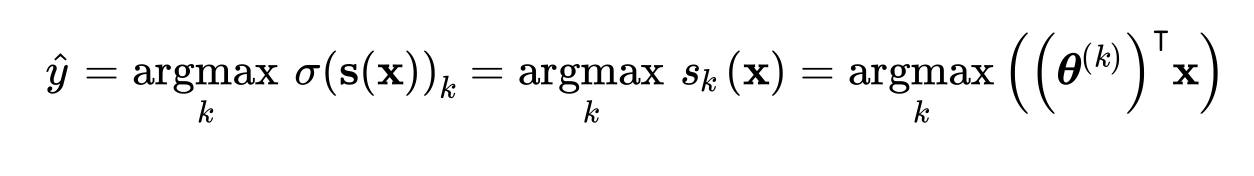

`argmax` 运算符返回最大化函数的变量的值。在这个方程中，它返回 k 的值，该值最大化了估计概率 $\sigma(s(x))_k$。

> TIP: Softmax回归分类器一次只预测一个类（即它是多类，而不是多输出），因此它只能与相互排斥的类一起使用，例如不同类型的植物。你不能用它来识别一张照片中的多个人。

> CROSS ENTROPY: 交叉熵起源于信息论。假设您想每天高效地传输有关天气的信息。如果有八个选项（sunny, rainy, etc.），您可以使用三位对每个选项进行编码，因为 $2^3 = 8$。交叉熵测量您每个选项实际发送的平均位数。如果您对天气的假设是完美的，交叉熵将等于天气本身的熵（即其内在的不可预测性）。但是，如果您的假设是错误的（例如，如果经常下雨），交叉熵将大于称为Kullback-Leibler（KL）散度的量。
>
> 两个概率分布p和q之间的交叉熵被定义为 $H(p, q) = -\sum_x p(x) log q(x)$（至少当分布是离散的时）。

让我们使用Softmax回归将  iris flowers 分为所有三种类。当您在两个以上的类别中进行训练时，Scikit-Learn 的 `LogisticRegression` 默认使用 one-versus-the-rest ，但您可以设置 `multi_class` 超参数为 `multinomial` 来将其转换为 Softmax Regression。您还必须指定一个支持Softmax回归的求解器，例如 ”lbfgs“ 求解器（有关更多详细信息，请参阅Scikit-Learn的文档）。默认情况下，它还应用l2正则化，您可以使用超参数 `C` 进行控制：

In [62]:
X = iris["data"][:, (2, 3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

因此，下次当你发现花瓣长5厘米，宽2厘米的 iris 时，你可以让你的模型告诉你它是什么类型的 iris，它会以94.2%的概率回答 Iris virginica(class2) (或5.8% 的 Iris versicolor):

In [63]:
softmax_reg.predict([[5, 2]])

array([2])

In [64]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

图4-25显示了由此产生的决策边界，由背景颜色表示。请注意，任何两个类别之间的决策边界都是线性的。该图还显示了  Iris versicolor  类的概率，由曲线表示（例如，标有 0.450 的线代表 45% 的概率边界）。请注意，该模型可以预测估计概率低于50%的类。例如，在所有决策边界相交的点，所有类的估计概率相等为33%。

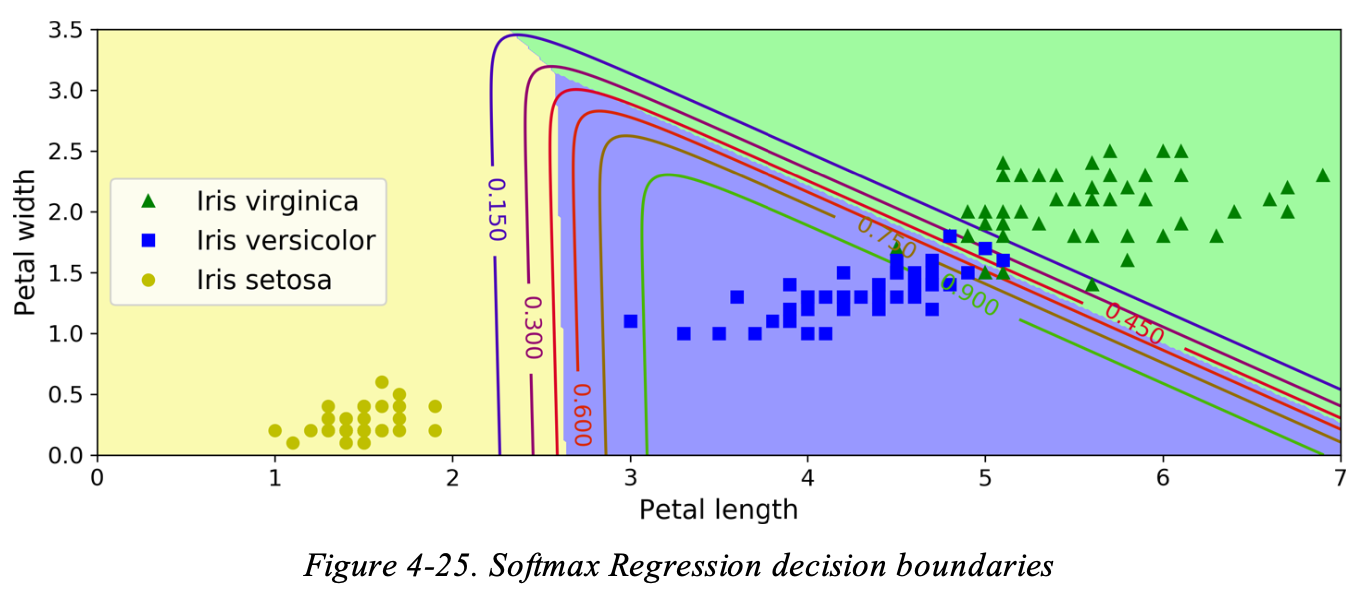